# Setup

In [414]:

# import libraries

import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import pickle

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

import tensorflow as tf
from tensorflow import keras
from keras import metrics



from sklearn.cluster import KMeans

In [3]:
# set display settings

warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

# Import Tabular Data and Define Column Groups

In [74]:
# specify columns and datatypes, load full consolidated sdss dataset, and create class map

# load column names from file into a list
sdss_headers = pd.read_csv('../data/processed/sdss_full.csv.gz', compression='gzip', header=0, index_col=0, nrows=0).columns.tolist()

# specify column groups
object_identifiers = ['dr8objid']
galaxy_identifiers = ['gz2_filenumber']
object_locations = ['ra', 'dec']
class_label_names = ['sdss_clean_class_name', 'stellar_subclass_MK', 'gz2_subclass_hubble']
class_label_codes = ['sdss_clean_class_code', 'stellar_subclass_code', 'gz2_subclass_code']
galaxy_binary_labels = [label for label in sdss_headers if 'flag' in label]
galaxy_filters = ['petroR90_r_log']
object_features = ['redshift_log', 'sum_p', 'u-r_p', 'g-i_p', 'r-z_p']
star_features = ['elodie_color_index', 'elodie_temperature', 'elodie_metallicity']
# consider adding galaxy features:  ratio of petro_radius to petro_brightness

# create a datatype dictionary for object_identifiers
col_dtypes = {col: 'string' for col in object_identifiers + galaxy_identifiers}

# load full consolidated sdss dataset
sdss_primary = pd.read_csv('../data/processed/sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)

# create map between class label codes and class label names
sdss_clean_class_map = dict(zip(sdss_primary[class_label_names[0]], sdss_primary[class_label_codes[0]]))
stellar_subclass_map = dict(zip(sdss_primary[class_label_names[1]], sdss_primary[class_label_codes[1]]))
gz2_subclass_map = dict(zip(sdss_primary[class_label_names[2]], sdss_primary[class_label_codes[2]]))
class_code_maps = [sdss_clean_class_map, stellar_subclass_map, gz2_subclass_map]

/tmp/ipykernel_477/1582399338.py:22: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  sdss_primary = pd.read_csv('../data/processed/sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)


# EDA - Investigate Classes and Features in Tabular Data

### Define and Call Helper Functions

In [4]:
# inspect the imported data

""" # display some data
display(sdss_primary.head(3))
display(sdss_primary.tail(3))
display(sdss_primary.sample(10))"""
 
# inspect dataframe
"""print(sdss_primary.shape)
print(sdss_primary.info())"""

'print(sdss_primary.shape)\nprint(sdss_primary.info())'

In [5]:
"""# investigate superclasses & simplified subclasses (categorical label names)

# create a helper function for investigating and plotting a subset from a column w/ categorical data
def investigate_clean_classes(df, column, filter=None):
    data = df[column]
    if filter:
        data = df[df['sdss_clean_class_name'] == filter][column]
    unclassified_count = data.isna().sum() + (data == 'unclassified').sum() + (data == 'unkonwn').sum()
    print(f"\n---------- {column} : {filter} ----------")
    print(f"The number of rows with classified values is: {len(data) - unclassified_count}")
    print(f"The number of unique labels is: {len(df[column].unique())}")
    data2 = data[data != 'unclassified']
    data2 = data2[data2 != 'unknown']
    plt.figure(figsize=(3, 2))
    sns.countplot(y=data2, order=data2.value_counts().index[:15], palette='viridis')
    #plt.suptitle(f"{column = }")
    #plt.tight_layout()
    plt.show()

investigate_clean_classes(sdss_primary, 'sdss_clean_class_name')
investigate_clean_classes(sdss_primary, 'gz2_subclass_hubble', 'galaxy')
investigate_clean_classes(sdss_primary, 'stellar_subclass_MK', 'star')"""

'# investigate superclasses & simplified subclasses (categorical label names)\n\n# create a helper function for investigating and plotting a subset from a column w/ categorical data\ndef investigate_clean_classes(df, column, filter=None):\n    data = df[column]\n    if filter:\n        data = df[df[\'sdss_clean_class_name\'] == filter][column]\n    unclassified_count = data.isna().sum() + (data == \'unclassified\').sum() + (data == \'unkonwn\').sum()\n    print(f"\n---------- {column} : {filter} ----------")\n    print(f"The number of rows with classified values is: {len(data) - unclassified_count}")\n    print(f"The number of unique labels is: {len(df[column].unique())}")\n    data2 = data[data != \'unclassified\']\n    data2 = data2[data2 != \'unknown\']\n    plt.figure(figsize=(3, 2))\n    sns.countplot(y=data2, order=data2.value_counts().index[:15], palette=\'viridis\')\n    #plt.suptitle(f"{column = }")\n    #plt.tight_layout()\n    plt.show()\n\ninvestigate_clean_classes(sdss_pri

In [6]:
"""# investigate histograms of feature columns, color-shaded by superclass

# generate a subset dataframe
df = sdss_primary[['sdss_clean_class_name'] + object_features + star_features]
df = df.sample(frac=0.5)

# define classes
classes = sdss_primary['sdss_clean_class_name'].unique()

# set a color palette with distinct colors for each category
colors = sns.color_palette('bright', n_colors=len(df['sdss_clean_class_name'].unique()))

# iterate over columns and create separate plots
for col in object_features + star_features:
    plt.figure(figsize=(3, 2))
    plt.xscale('linear')
    log_choice = False
    denom = df[col].min()
    if denom == 0:
        denom = 0.001
    if abs(df[col].max() / denom) > 50:
        df[col] = df[col].replace(0, 0.001)
        log_choice = True
        plt.xscale('symlog')  
    for class_label, color in zip(classes, colors):
        if 'elodie' in col:
            if class_label == 'star':
                sns.histplot(df[df['sdss_clean_class_name'] == class_label][col], bins=25, label=class_label, log_scale=log_choice)
        else:
            sns.histplot(df[df['sdss_clean_class_name'] == class_label][col], bins=25, label=class_label, log_scale=log_choice)
    plt.title(col)
    plt.legend()
    plt.show()"""

"# investigate histograms of feature columns, color-shaded by superclass\n\n# generate a subset dataframe\ndf = sdss_primary[['sdss_clean_class_name'] + object_features + star_features]\ndf = df.sample(frac=0.5)\n\n# define classes\nclasses = sdss_primary['sdss_clean_class_name'].unique()\n\n# set a color palette with distinct colors for each category\ncolors = sns.color_palette('bright', n_colors=len(df['sdss_clean_class_name'].unique()))\n\n# iterate over columns and create separate plots\nfor col in object_features + star_features:\n    plt.figure(figsize=(3, 2))\n    plt.xscale('linear')\n    log_choice = False\n    denom = df[col].min()\n    if denom == 0:\n        denom = 0.001\n    if abs(df[col].max() / denom) > 50:\n        df[col] = df[col].replace(0, 0.001)\n        log_choice = True\n        plt.xscale('symlog')  \n    for class_label, color in zip(classes, colors):\n        if 'elodie' in col:\n            if class_label == 'star':\n                sns.histplot(df[df['sdss

# Define Helper Functions for Tabular Data

In [180]:
# define a helper function to extract only objects of interest, given a specified set of classes

def jsm_specify_objects(objects='superclass'):
    
    if objects == 'superclass':
        class_column = class_label_codes[0:1] #'sdss_clean_class_code'
        class_map = sdss_clean_class_map
        sdss_secondary = sdss_primary[sdss_primary['sdss_clean_class_name'] != 'unclassified']
    elif objects == 'stars':
        class_column = class_label_codes[1:2] #'stellar_subclass_MK'
        class_map = stellar_subclass_map
        sdss_secondary = sdss_primary[sdss_primary['stellar_subclass_MK'] != 'unclassified']
    elif objects == 'galaxies':
        class_column = class_label_codes[2:3] #'gz2_subclass_hubble'
        class_map = gz2_subclass_map
        sdss_secondary = sdss_primary[sdss_primary['gz2_subclass_hubble'] != 'unclassified']

    # define label codes and names
    sorted_items = sorted(class_map.items(), key=lambda x: x[1])
    label_codes = [item[1] for item in sorted_items]
    label_names = [item[0] for item in sorted_items]
    if 'unclassified' in label_names:
        label_codes = label_codes[:-1]
        label_names = label_names[:-1]
    
    return class_column, sdss_secondary, label_codes, label_names

In [384]:
# define a helper function to facilitate rebalancing -- shuffle only ('none'), sample equal numbers of least-common label ('equal'), or apply SMOTE ('smote')

def jsm_rebalance(X, y, class_column, mode='none'):
    
    indices = X.index.tolist()
    random.shuffle(indices)
    X_resampled = X.loc[indices]
    y_resampled = y.loc[indices]
    
    if mode == 'equal':
        grouped_df = X_resampled.groupby(y_resampled[class_column[0]], group_keys=False)
        X_resampled = grouped_df.apply(lambda x: x.sample(min(len(x), y_resampled[class_column].value_counts().min())))
        y_resampled = y_resampled.loc[X_resampled.index]
        X_resampled = X_resampled.reset_index(drop=True)
        y_resampled = y_resampled.reset_index(drop=True)
    
    elif mode == 'smote':
        smote = SMOTE()
        X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)
    
    return X_resampled, y_resampled

In [21]:
# define a helper function to split into subsets using either np/pd or sklearn

def jsm_split_subsets(df, feature_cols, label_cols, ratios, mode='default', seed=38):
    
    np.random.seed(seed)
    train_ratio = ratios[0]
    validation_ratio = ratios[1]
    test_ratio = ratios[2]
    
    if mode == 'default':
        num_rows = df.shape[0]
        indices = np.random.permutation(num_rows)
        train_end = int(train_ratio * num_rows)
        validation_end = int((train_ratio + validation_ratio) * num_rows)
        train_indices = indices[:train_end]
        validation_indices = indices[train_end:validation_end]
        test_indices = indices[validation_end:]
        train_set = df.iloc[train_indices]
        validation_set = df.iloc[validation_indices]
        test_set = df.iloc[test_indices]
        
    elif mode == 'sklearn':
        train_set, temp_set = train_test_split(df, test_size=(1 - train_ratio))
        validation_set, test_set = train_test_split(temp_set, test_size=test_ratio/(validation_ratio + test_ratio))
    
    X_train = train_set[feature_cols]
    y_train = train_set[label_cols]
    X_validation = validation_set[feature_cols]
    y_validation = validation_set[label_cols]
    X_test = test_set[feature_cols]
    y_test = test_set[label_cols]
    
    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [ ]:
# define a helper function to drop objects belonging to extremely rare classes
# NOTE: this is not yet implmeneted

def jsm_drop_minorities():
    pass

In [6]:
# define a helper function perform PCA on a given data subset and visualize train results (esp. feature importance)

def pca_features(X_train, X_validation=None, X_test=None):
    
    # fit the object_identifiers to a PCA model
    pca = PCA().fit(X_train)
    #print(type(pca))

    # evaluate the PCA loadings
    loadings = pd.DataFrame(
        data=pca.components_.T * np.sqrt(pca.explained_variance_ratio_), 
        columns=[f'PC{i}' for i in range(1, len(object_features) + 1)],
        index=object_features
    )
    loadings.head()
    
    # display some data
    """print(loadings.shape)
    display(loadings.head(5))"""
    
    # plot the cumulative variance by # of principal components
    # NOTE: the first PC already explaines ~80% of the total variance in the dataset
    plt.figure(figsize=(3,2))
    plt.plot(pca.explained_variance_ratio_.cumsum())
    plt.show()

    # visualize correlations between first PC and object_features
    pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
    pc1_loadings = pc1_loadings.reset_index()
    pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']
    plt.figure(figsize=(3,2))
    plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
    plt.title('PCA loading scores (first principal component)', size=12)
    plt.xticks(rotation='vertical')
    plt.show()

    # visualize correlations between second PC and object_features
    pc2_loadings = loadings.sort_values(by='PC2', ascending=False)[['PC2']]
    pc2_loadings = pc2_loadings.reset_index()
    pc2_loadings.columns = ['Attribute', 'CorrelationWithPC1']
    plt.figure(figsize=(3,2))
    plt.bar(x=pc2_loadings['Attribute'], height=pc2_loadings['CorrelationWithPC1'], color='#087E8B')
    plt.title('PCA loading scores (second principal component)', size=12)
    plt.xticks(rotation='vertical')
    plt.show()
    
    return loadings

In [7]:
# define a helper function to create pandas dataframe for visualizing the model in scatter and tabular formats: X7_train (ndarray) --> pca_examples_table (df)

def model_examples(X_ndarray, y_df):

    # convert ndarray to pd df holding PC features
    temp1 = pd.DataFrame(data=X_ndarray, columns=['PC1','PC2'])
    temp1.reset_index(drop=True, inplace=True)

    # add labeled rows to df
    temp2 = y_df[[class_label_codes[0]]]
    temp2.reset_index(drop=True, inplace=True)
    pca_df = pd.concat([temp1, temp2], axis=1)
    
    # display some data
    """print(pca_df.shape)
    display(pca_df.head(5))"""

    # generate a scatterplot of the first two PC's from the df
    pca_df = pca_df.sample(frac=0.1)
    plt.figure(figsize=(4,3))
    for class_code in pca_df[class_label_codes[0]].unique():
        class_data = pca_df[pca_df[class_label_codes[0]] == class_code]
        plt.scatter(class_data['PC1'], class_data['PC2'], label=f'Class {class_code}', cmap='viridis', s=1, alpha=0.5)
    plt.legend()
    plt.show()
    
    return pca_df

# generate a 3d scatterplot of the first three PC's from the df
# NOTE: this isn't yet implemented

In [10]:
# define a helper function to load existing or save new model

def jsm_fit_model(model, X, y, name='misc', mode='load'):
    
    if mode == 'load':
        model = pickle.load(open(f"../models/model_{name}.sav", 'rb'))
    elif mode == 'save':
        model.fit(X, y)
        pickle.dump(model, open(f"../models/model_{name}.sav", 'wb'))
        
    return model

In [398]:
# define a helper function to make predictions using a model print

def jsm_predict(model, X, y, labels=[0,1,2]):
    
    y_pred = model.predict(X)
    
    acs = accuracy_score(y, y_pred)
    ps = precision_score(y, y_pred, average='weighted')
    rs = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    metric = {"Accuracy Score": acs, "Precision Score": ps, "Recall Score": rs, "F1 Score": f1}
    print(metric)
    
    class_report = classification_report(y, y_pred)
    print(class_report)
    
    #print(type(y))
    #print(type(y_pred))
    cm = confusion_matrix(y, y_pred, labels=labels)
    cm_display = ConfusionMatrixDisplay(cm).plot()
    plt.show()


# Preprocessing Tabular Data

### Specify object set for classification

In [388]:
# specify secondary dataset based on inclusion of all objects ('superclass'), only labeled galaxies ('galaxies'), or only labeled stars ('stars')

class_column, sdss_secondary, label_codes, label_names = jsm_specify_objects('superclass')

### Split Data into Train, Validation, and Test Subsets

In [389]:
# generate subsets (return as df's)

X_train, y_train, X_validation, y_validation, X_test, y_test = jsm_split_subsets(sdss_secondary, object_features, class_column, [0.6, 0.2, 0.2], mode='sklearn')
display(X_train.head(5))
print(X_train.shape)
display(y_train.value_counts())

,redshift_log,sum_p,u-r_p,g-i_p,r-z_p
176373,-2.210827,82.03548,2.82417,1.31543,0.72571
1051074,-3.873121,109.07963,2.55924,2.03774,0.81543
659181,-3.889277,95.30601,1.25397,0.43818,0.12950
450533,-2.266721,88.38025,2.65379,1.41082,0.88609
111701,-2.256328,87.44620,2.86210,1.33479,0.72691


(653563, 5)


sdss_clean_class_code
0                        318845
2                        221070
1                        113648
Name: count, dtype: int64

### Rebalance Dataset

In [390]:
# balance dataset (returns as df)

# NOTE: this isn't yet implemented
X_train, y_train = jsm_rebalance(X_train, y_train, class_column, mode='none')
display(X_train.head(5))
print(X_train.shape)
display(y_train.value_counts())

,redshift_log,sum_p,u-r_p,g-i_p,r-z_p
290328,-2.456783,88.57478,1.95155,0.98194,0.59821
423824,-2.081771,86.09483,2.81909,1.39984,0.80058
702381,-3.927208,81.80643,1.22290,0.39024,0.13401
816133,-3.929202,83.74133,1.88164,0.85490,0.38764
31513,-2.411625,83.44995,2.53955,1.34110,0.77665


(653563, 5)


sdss_clean_class_code
0                        318845
2                        221070
1                        113648
Name: count, dtype: int64

### X0...: Z-Standardize (All Features)

In [391]:
# fitting all object_features to a model -- z-standardize (all)

# apply z-standardization (return as ndarrays) -- baseline
scaler = StandardScaler()

# z-standardize data (returns as ndarray)
X0_train = scaler.fit_transform(X_train)
X0_validation = scaler.transform(X_validation)
X0_test = scaler.transform(X_test)
print(X0_train.shape)
print(X0_train[0:5,0:5])

(653563, 5)
[[-0.0936976  -0.39233873 -0.18352241 -0.12639916 -0.02117002]
 [ 0.15497268 -0.68853967  0.60694869  0.43834099  0.34672318]
 [-1.06873636 -1.20073877 -0.84744197 -0.92600852 -0.86505017]
 [-1.0700581  -0.96963765 -0.24722188 -0.29807801 -0.4039702 ]
 [-0.06375385 -1.00443957  0.35224195  0.35896115  0.30322027]]


### X1...: Z-Standardize (only 'redshift_log')

In [15]:
# fitting some object_features to a model -- z-standardize (redshift_log)

# apply z-standardization (return as ndarrays) -- only redshift_log
scaler = StandardScaler()

# z-standardize data (return as ndarray)
X1_train = scaler.fit_transform(X_train[['redshift_log']])
X1_validation = scaler.transform(X_validation[['redshift_log']])
X1_test_scaled = scaler.transform(X_test[['redshift_log']])
print(X1_train.shape)
print(X1_train[0:5,0:5])

(653563, 1)
[[-1.056895  ]
 [ 1.66751654]
 [-1.05095177]
 [-1.07587632]
 [ 0.21981948]]


### X2...: Z-Standardize (only 'redshift_log' and 'g-i_p')

In [16]:
# fitting some object_features to a model -- z-standardize (redshift_log & g-i_p)

# apply z-standardization (return as ndarrays) -- redshift_log & g-i_p
scaler = StandardScaler()

# z-standardize data (return as ndarrays)
X2_train = scaler.fit_transform(X_train[['redshift_log', 'g-i_p']])
X2_validation = scaler.transform(X_validation[['redshift_log', 'g-i_p']])
X2_test = scaler.transform(X_test[['redshift_log', 'g-i_p']])
print(X2_train.shape)
print(X2_train[0:5,0:5])

(653563, 2)
[[-1.056895    0.73886005]
 [ 1.66751654 -0.41595856]
 [-1.05095177  4.0951247 ]
 [-1.07587632 -0.91117041]
 [ 0.21981948  0.07157746]]


### X3...: Z-Standardize and Weight (All Features)

In [20]:
# fitting all object_features to a model -- weighted

# NOTE: the weights are determined from physical reasons (i.e. the first feature is from the spectroscopic detector and the other4 features are from the photometric detector)
scalar_values = [0.5, 0.5/4, 0.5/4, 0.5/4, 0.5/4]

# apply weights to z-standardized data (return as ndarrays)
X3_train = X0_train[:, :] * scalar_values
X3_validation = X0_validation[:, :] * scalar_values
X_test = X0_test[:, :] * scalar_values
print(X3_train.shape)
print(X3_train[0:5,0:5])

(653563, 5)
[[ 0.22604887 -0.01605946  0.09244607  0.10256378  0.05121201]
 [ 0.7939555   0.2475538  -0.17704089 -0.13172602 -0.07655848]
 [-0.01198093 -0.09300279  0.02813727  0.01907406  0.01967558]
 [ 0.02099474 -0.10427687  0.08967386  0.07707344  0.07145686]
 [ 0.67982946  0.15999853 -0.18101015 -0.16552563 -0.04529929]]


### X7...: - Principal Components
All Features --> Two Features


-----X7_train-----
(653563, 2)
[[-0.98895999 -0.40587245]
 [ 2.34935898 -2.07481796]
 [-0.38204347  0.49956843]
 [-1.13108512  0.34366861]
 [ 2.2541527  -1.44897982]]

-----X_pca_loadings-----


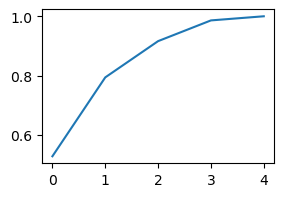

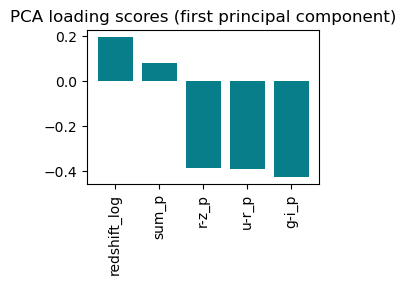

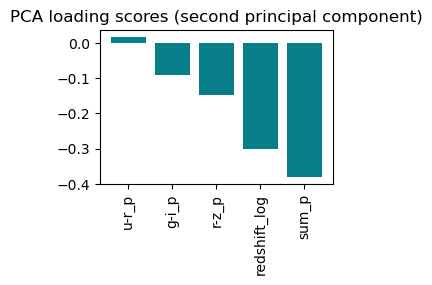


-----X_pca_examples-----


/tmp/ipykernel_11965/3362372887.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(class_data['PC1'], class_data['PC2'], label=f'Class {class_code}', cmap='viridis', s=1, alpha=0.5)


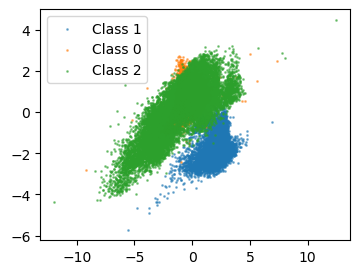

'print(X_pca_examples.shape)\ndisplay(X_pca_examples.head(5))'

In [21]:
# fiting all object_features to a model -- PCA

print('\n-----X7_train-----')
X7_train = PCA(n_components=2).fit_transform(X0_train)
print(X7_train.shape)
print(X7_train[0:5,0:5])

print('\n-----X_pca_loadings-----')
X_pca_loadings = pca_features(X0_train)
"""print(X_pca_loadings.shape)
display(X_pca_loadings.head(5))"""

print('\n-----X_pca_examples-----')
X_pca_examples = model_examples(X7_train, y_train)
"""print(X_pca_examples.shape)
display(X_pca_examples.head(5))"""

# Investigate Models for Tabular Data

### model_dt:  Decision Tree Classifier

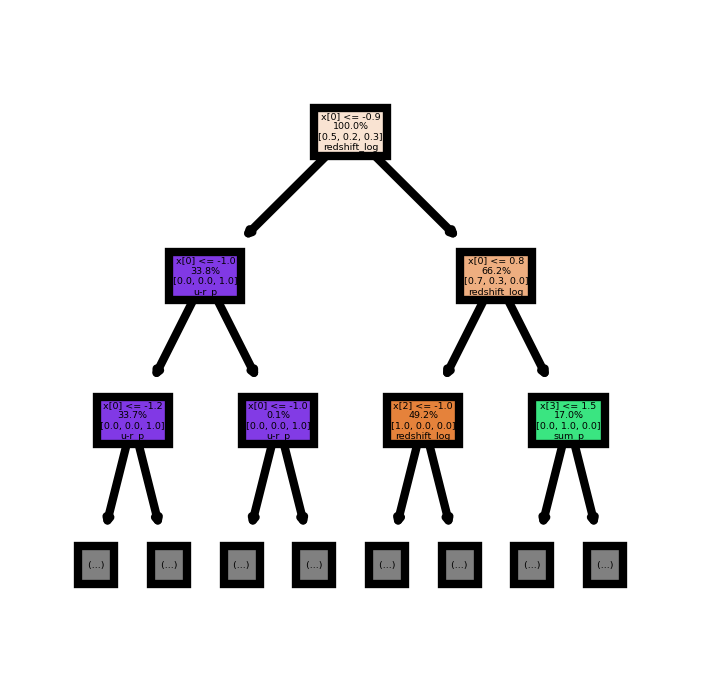


	TEST SUBSET:
{'Accuracy Score': 0.9983995422017464, 'Precision Score': 0.9983998105284232, 'Recall Score': 0.9983995422017464, 'F1 Score': 0.9983982582672187}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    318845
           1       1.00      0.99      1.00    113648
           2       1.00      1.00      1.00    221070

    accuracy                           1.00    653563
   macro avg       1.00      1.00      1.00    653563
weighted avg       1.00      1.00      1.00    653563

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


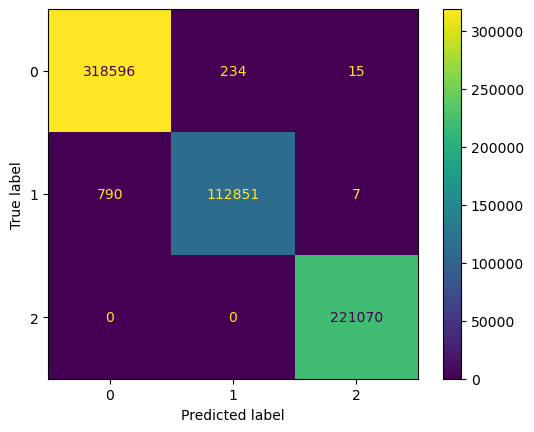


	VALIDATION SUBSET:
{'Accuracy Score': 0.9983842464024236, 'Precision Score': 0.9983844920057249, 'Recall Score': 0.9983842464024236, 'F1 Score': 0.998382914095797}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105892
           1       1.00      0.99      1.00     37962
           2       1.00      1.00      1.00     74001

    accuracy                           1.00    217855
   macro avg       1.00      1.00      1.00    217855
weighted avg       1.00      1.00      1.00    217855

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


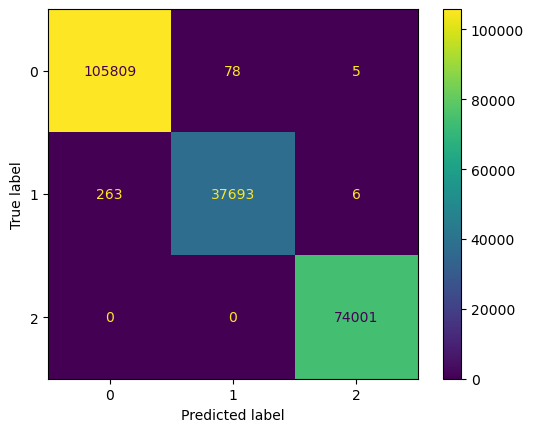

In [392]:
# model as decision tree classifier
 
# setup decision tree model
dt = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=5)#, class_weight = {}#class_weight={0:1.1, 1:1, 2:1.15}, random_state=5)

# fit random forest classifier
model_dt = jsm_fit_model(dt, X0_train, y_train, 'dt', 'save')
"""dt.fit(X0_train, y_train)"""

# plot decision tree
plt.figure(figsize=(1.25, 1.25), dpi=600)
tree.plot_tree(model_dt, filled=True, label='none', class_names=object_features, max_depth=2, proportion=True, impurity=False, precision=1)
#plt.figure(figsize=(1.25, 1.25), dpi=600)
plt.show()

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTEST SUBSET:")
jsm_predict(model_dt, X0_train, y_train, labels=[0,1,2])

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_dt, X0_validation, y_validation, labels=[0,1,2])

### model_rf:  Random Forest Classifier


	TEST SUBSET:
{'Accuracy Score': 0.9973422608072978, 'Precision Score': 0.9973458811291559, 'Recall Score': 0.9973422608072978, 'F1 Score': 0.9973377933735642}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    318845
           1       1.00      0.99      0.99    113648
           2       1.00      1.00      1.00    221070

    accuracy                           1.00    653563
   macro avg       1.00      1.00      1.00    653563
weighted avg       1.00      1.00      1.00    653563



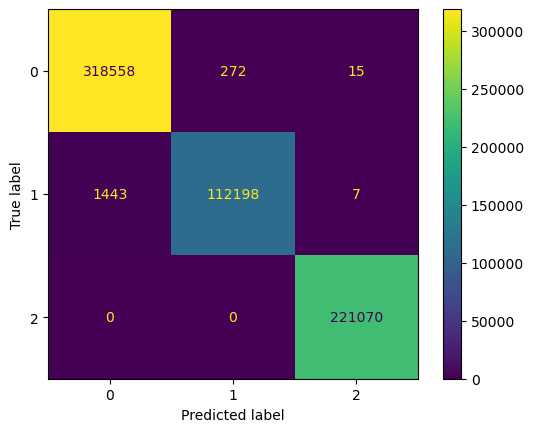


	VALIDATION SUBSET:
{'Accuracy Score': 0.9974478437492827, 'Precision Score': 0.9974506960214843, 'Recall Score': 0.9974478437492827, 'F1 Score': 0.997443821446798}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105892
           1       1.00      0.99      0.99     37962
           2       1.00      1.00      1.00     74001

    accuracy                           1.00    217855
   macro avg       1.00      1.00      1.00    217855
weighted avg       1.00      1.00      1.00    217855



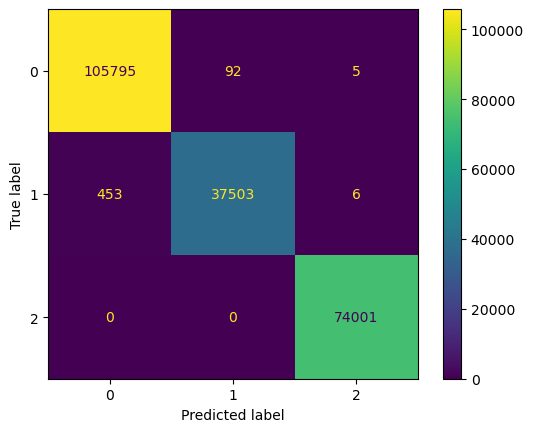

In [71]:
# model as a random forest classifier

# setup random forest model
rf = RandomForestClassifier(n_estimators=500, max_depth=3, random_state=38)

# fit random forest classifier
model_rf = jsm_fit_model(rf, X0_train, y_train, 'rf', 'load')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTEST SUBSET:")
jsm_predict(model_rf, X0_train, y_train, labels=[0,1,2])

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_rf, X0_validation, y_validation, labels=[0,1,2])


### model_knn: KNN Classifier


	TEST SUBSET:
{'Accuracy Score': 0.999709285868386, 'Precision Score': 0.9997092871884449, 'Recall Score': 0.999709285868386, 'F1 Score': 0.999709277385657}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    318845
           1       1.00      1.00      1.00    113648
           2       1.00      1.00      1.00    221070

    accuracy                           1.00    653563
   macro avg       1.00      1.00      1.00    653563
weighted avg       1.00      1.00      1.00    653563



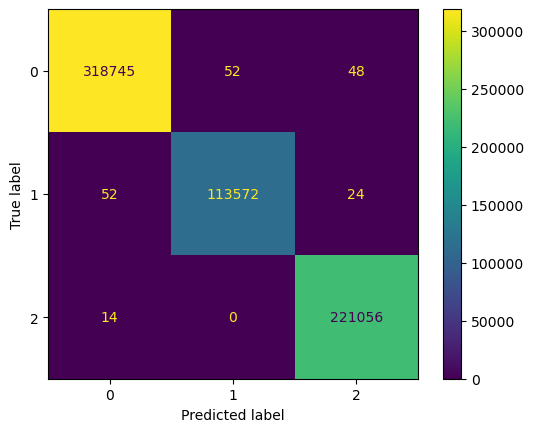


	VALIDATION SUBSET:
{'Accuracy Score': 0.9994445847008331, 'Precision Score': 0.9994445962621554, 'Recall Score': 0.9994445847008331, 'F1 Score': 0.9994445583608095}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    105892
           1       1.00      1.00      1.00     37962
           2       1.00      1.00      1.00     74001

    accuracy                           1.00    217855
   macro avg       1.00      1.00      1.00    217855
weighted avg       1.00      1.00      1.00    217855



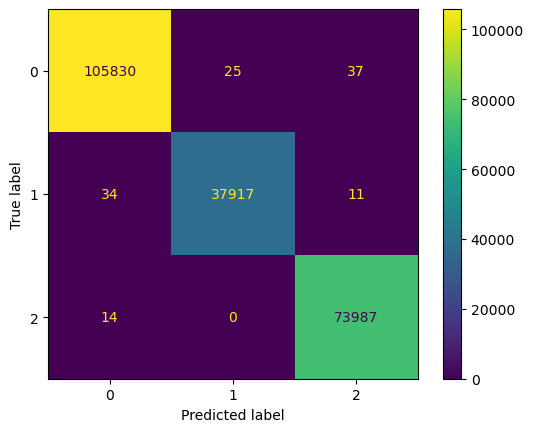

In [400]:
# model as a k nearest neighbors classifier

# setup random forest model
knn = KNeighborsClassifier(n_neighbors=3)

# fit random forest classifier
model_knn = jsm_fit_model(knn, X0_train, y_train.values.ravel(), 'knn', 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTEST SUBSET:")
jsm_predict(model_knn, X0_train, y_train, labels=[0,1,2])

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_knn, X0_validation, y_validation, labels=[0,1,2])

### model_mlrc: Multiclass Logistic Regression Classifier

### model_km: Clustering

### model_h: Hierarchical Clustering

### model_mlp: Multilayer Perceptron Model